# Training

In [1]:
import mlflow
from mlflow import log_param, log_metric, log_artifact
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import numpy as np

In [2]:
# Set MLflow experiment
mlflow.set_experiment('indoor_outdoor_classifier')

## Dataset Creation

In [3]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((90, 120)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((90, 120)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
# Create datasets
image_datasets = {
    'train': datasets.ImageFolder('../data/train', data_transforms['train']),
    'val': datasets.ImageFolder('../data/val', data_transforms['val'])
}

In [5]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=4, shuffle=False)
}

In [6]:
n_train = 200
n_val = 93
dataset_sizes = {'train': n_train*2, 'val': n_val*2}

In [7]:
class_names = image_datasets['train'].classes
print(class_names)

['indoor', 'outdoor']


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

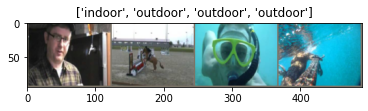

In [9]:
# Visualize data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train Model

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            log_metric(f'{phase}_loss', epoch_loss)
            log_metric(f'{phase}_acc', np.float64(epoch_acc.numpy()))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Logging
    log_param('time', time_elapsed)
    log_param('best_vall_acc', np.float64(best_acc.numpy()))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
# Download resnet, change outputs, add things like optimizer and loss

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
# Train model
mlflow.start_run()

n_epochs = 10
    
# Log parameters
log_param('image_shape', (90, 120))
log_param('n_train', n_train)
log_param('n_val', n_val)
log_param('classes', class_names)
log_param('n_epochs', n_epochs)

# Train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=n_epochs)
    
# Save model
mlflow.pytorch.log_model(model_ft, "models")

#torch.save(model_ft, '../models/resnet18.pt')
#log_artifact('../models/resnet18.pt')

2020/10/14 23:04:50 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Epoch 0/9
----------
train Loss: 0.7893 Acc: 0.6725
val Loss: 0.6066 Acc: 0.7151

Epoch 1/9
----------
train Loss: 0.6634 Acc: 0.7475
val Loss: 0.6196 Acc: 0.7527

Epoch 2/9
----------
train Loss: 0.6627 Acc: 0.7375
val Loss: 0.8395 Acc: 0.7473

Epoch 3/9
----------
train Loss: 0.8840 Acc: 0.7600
val Loss: 1.6109 Acc: 0.6505

Epoch 4/9
----------
train Loss: 0.5611 Acc: 0.8025
val Loss: 0.5106 Acc: 0.8011

Epoch 5/9
----------
train Loss: 0.4853 Acc: 0.8325
val Loss: 0.8039 Acc: 0.7366

Epoch 6/9
----------
train Loss: 0.4363 Acc: 0.8450
val Loss: 0.5690 Acc: 0.7796

Epoch 7/9
----------
train Loss: 0.3524 Acc: 0.8625
val Loss: 0.5396 Acc: 0.8065

Epoch 8/9
----------
train Loss: 0.2433 Acc: 0.9050
val Loss: 0.5494 Acc: 0.7796

Epoch 9/9
----------
train Loss: 0.2643 Acc: 0.9050
val Loss: 0.4862 Acc: 0.8011

Training complete in 3m 38s
Best val Acc: 0.806452


## Load saved model
```python
# Load model
saved_model = torch.load('../models/resnet18.pt')
saved_model.eval()
```

## Visualize model

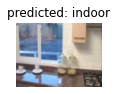

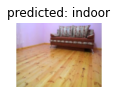

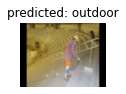

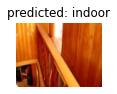

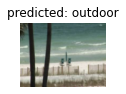

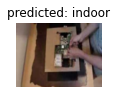

In [14]:
visualize_model(model_ft)

In [17]:
!jupyter nbconvert Training.ipynb --to='html' --output="Training.html"

[NbConvertApp] Converting notebook Training.ipynb to html
[NbConvertApp] Writing 670440 bytes to Training.html


In [19]:
log_artifact('Training.html')

## End MLflow run

In [21]:
mlflow.end_run()